# Import

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from torch.utils.data import DataLoader, WeightedRandomSampler

import pytorch_lightning as pl
from torchmetrics import F1Score
from torchmetrics import MetricCollection

import multiprocessing

In [2]:
# multiprocessing.set_start_method('fork')

In [3]:
pl.seed_everything(seed=42)

Seed set to 42


42

# Utils

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Darknet53

In [5]:
class ConvBNReLU(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        kernel_size: int,
        stride: int,
        padding: int,
    ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=in_dim,
                out_channels=out_dim,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(
        self,
        in_dim: int,
    ):
        super().__init__()
        hidden_dim = in_dim // 2
        self.layers = nn.Sequential(
            ConvBNReLU(
                in_dim=in_dim,
                out_dim=hidden_dim,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            ConvBNReLU(
                in_dim=hidden_dim,
                out_dim=in_dim,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.layers(x)

In [7]:
class Darknet53(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.num_classes = num_classes

        # (in_dim, out_dim, repeated, type, stride)
        config = (
            (3, 32, 1, 'conv', 1),
            (32, 64, 1, 'conv', 2),
            (64, 64, 1, 'residual', 1),
            (64, 128, 1, 'conv', 2),
            (128, 128, 2, 'residual', 1),
            (128, 256, 1, 'conv', 2),
            (256, 256, 8, 'residual', 1),
            (256, 512, 1, 'conv', 2),
            (512, 512, 8, 'residual', 1),
            (512, 1024, 1, 'conv', 2),
            (1024, 1024, 4, 'residual', 1),
        )

        self.features = nn.ModuleList([])
        for in_dim, out_dim, rep, layer, stride in config:
            for r in range(rep):
                if layer == 'conv':
                    self.features.append(
                        ConvBNReLU(
                            in_dim=in_dim,
                            out_dim=out_dim,
                            kernel_size=3,
                            stride=stride,
                            padding=1,
                        )
                    )
                elif layer == 'residual':
                    self.features.append(
                        ResidualBlock(
                            in_dim=in_dim,
                        )
                    )

        self.avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=1024,
                out_features=num_classes,
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for block in self.features:
            x = block(x)

        out = self.avg_pool(x)
        out = self.classifier(out)
        
        return out

In [8]:
x = torch.randn(32, 3, 256, 256)
Darknet53(3, 1024)(x).shape

torch.Size([32, 1024])

In [9]:
count_parameters(Darknet53(3, 1024))

41634528

In [10]:
darknet_model = Darknet53(3, 42)
darknet_model.features[5].layers[0]

ConvBNReLU(
  (layers): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
)

In [11]:
def load_darknet_weights(weights_path, module_list):
    """Parses and loads the weights stored in 'weights_path'"""

    # Open the weights file
    with open(weights_path, "rb") as f:
        # First five are header values
        header = np.fromfile(f, dtype=np.int32, count=5)
        header_info = header  # Needed to write header when saving weights
        seen = header[3]  # number of images seen during training
        weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

    # Establish cutoff for loading backbone weights
    cutoff = None
    # If the weights file has a cutoff, we can find out about it by looking at the filename
    # examples: darknet53.conv.74 -> cutoff is 74
    filename = os.path.basename(weights_path)
    if ".conv." in filename:
        try:
            cutoff = int(filename.split(".")[-1])  # use last part of filename
        except ValueError:
            pass

    ptr = 0
    for i, module in enumerate(module_list):
        if i == cutoff:
            break

        if isinstance(module, ConvBNReLU):
            conv_layer = module.layers[0]
            
            # Load BN bias, weights, running mean and running variance
            bn_layer = module.layers[1]
            num_b = bn_layer.bias.numel()  # Number of biases
            # Bias
            bn_b = torch.from_numpy(
                weights[ptr: ptr + num_b]).view_as(bn_layer.bias)
            bn_layer.bias.data.copy_(bn_b)
            ptr += num_b
            # Weight
            bn_w = torch.from_numpy(
                weights[ptr: ptr + num_b]).view_as(bn_layer.weight)
            bn_layer.weight.data.copy_(bn_w)
            ptr += num_b
            # Running Mean
            bn_rm = torch.from_numpy(
                weights[ptr: ptr + num_b]).view_as(bn_layer.running_mean)
            bn_layer.running_mean.data.copy_(bn_rm)
            ptr += num_b
            # Running Var
            bn_rv = torch.from_numpy(
                weights[ptr: ptr + num_b]).view_as(bn_layer.running_var)
            bn_layer.running_var.data.copy_(bn_rv)
            ptr += num_b
    
            # Load conv. weights
            num_w = conv_layer.weight.numel()
            conv_w = torch.from_numpy(
                weights[ptr: ptr + num_w]).view_as(conv_layer.weight)
            conv_layer.weight.data.copy_(conv_w)
            ptr += num_w
        else:
            for layer in module.layers:
                conv_layer = layer.layers[0]
                
                # Load BN bias, weights, running mean and running variance
                bn_layer = layer.layers[1]
                num_b = bn_layer.bias.numel()  # Number of biases
                # Bias
                bn_b = torch.from_numpy(
                    weights[ptr: ptr + num_b]).view_as(bn_layer.bias)
                bn_layer.bias.data.copy_(bn_b)
                ptr += num_b
                # Weight
                bn_w = torch.from_numpy(
                    weights[ptr: ptr + num_b]).view_as(bn_layer.weight)
                bn_layer.weight.data.copy_(bn_w)
                ptr += num_b
                # Running Mean
                bn_rm = torch.from_numpy(
                    weights[ptr: ptr + num_b]).view_as(bn_layer.running_mean)
                bn_layer.running_mean.data.copy_(bn_rm)
                ptr += num_b
                # Running Var
                bn_rv = torch.from_numpy(
                    weights[ptr: ptr + num_b]).view_as(bn_layer.running_var)
                bn_layer.running_var.data.copy_(bn_rv)
                ptr += num_b
        
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(
                    weights[ptr: ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    return module_list

In [12]:
weights = load_darknet_weights('yolo/darknet53.conv.74', darknet_model.features)

# Dataset

In [13]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=(0.6, 1.5), contrast=(0.6, 1.5)),
    transforms.GaussianBlur(3),
    transforms.RandomRotation((-60, 60)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ToTensor(),

    # imagenet weights
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

    # imagenet weights
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [14]:
train_dataset = ImageFolder('~/Downloads/journey-springfield/train/simpsons_dataset')
test_dataset = ImageFolder('~/Downloads/journey-springfield/testset')

In [15]:
train_size = int(len(train_dataset) * 0.75)
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [16]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = train_transform

test_dataset.transform = val_transform

In [17]:
classes = [sample[1] for sample in train_dataset.dataset.samples]

In [18]:
%%time
class_dist = pd.Series(classes).value_counts()

weights = 1 / class_dist.values
class_weights = dict(zip(class_dist.index, weights))

sample_weights = [class_weights[train_dataset.dataset[ind][1]] for ind in train_dataset.indices]

CPU times: user 10min 6s, sys: 2min 12s, total: 12min 19s
Wall time: 1min 37s


In [19]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

In [20]:
batch_size: int = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    # num_workers=8,
    # persistent_workers=True,
    # pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=8,
    # persistent_workers=True,
    # pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=8,
    # persistent_workers=True,
    # pin_memory=True,
)

# Train

In [21]:
loss_epoch = []

In [22]:
class DarknetLightning(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        t_max,
    ):
        super().__init__()

        self.model = model
        self.criterion = criterion
        self.t_max = t_max

        self.save_hyperparameters(ignore=['model', 'criterion'])

        metric = MetricCollection({'f1': F1Score(task='multiclass', num_classes=42)})
        self.train_metric = metric.clone(prefix='train/')
        self.valid_metric = metric.clone(prefix='valid/')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def evaluate(self, batch, metric_func):
        output = self.model(batch[0])
        
        # eval loss
        loss = self.criterion(output, batch[1])

        # eval metric
        metric = metric_func(output.argmax(dim=-1), batch[1])

        return loss, metric
    
    def training_step(self, batch, batch_idx):
        train_loss, train_metric = self.evaluate(batch, self.train_metric)
        self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log_dict(train_metric, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        loss_epoch.append(train_loss.item())
        return train_loss

    def validation_step(self, batch, batch_idx):
        valid_loss, val_metric = self.evaluate(batch, self.valid_metric)
        self.log("valid_loss", valid_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log_dict(val_metric, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return valid_loss

    def predict_step(self, batch, batch_idx):
        pred = self.model(batch[0]).argmax(dim=-1)
        return pred
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), 1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.t_max,
        )
        return [optimizer], [scheduler]

In [23]:
class CustomClassificationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = None
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, output, target):
        self.loss = self.criterion(output, target)
        return self.loss

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [24]:
num_epochs = 15

In [25]:
criterion = CustomClassificationLoss()

model = DarknetLightning(
    model=darknet_model,
    criterion=criterion,
    t_max=int(len(train_dataset) / (batch_size * 2) + 1) * num_epochs,
)

In [26]:
trainer = pl.Trainer(
    accelerator='mps',
    # callbacks=[LogGradientNorm(), LogWeightNorm(),],
    max_epochs=num_epochs,
    accumulate_grad_batches=2,
    precision="bf16-mixed",
    log_every_n_steps=1,
    enable_checkpointing=True,
    enable_progress_bar=True,
    gradient_clip_val=3,
    use_distributed_sampler=True,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ruasvmv/common/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [27]:
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)


  | Name         | Type                     | Params | Mode 
------------------------------------------------------------------
0 | model        | Darknet53                | 40.6 M | train
1 | criterion    | CustomClassificationLoss | 0      | train
2 | train_metric | MetricCollection         | 0      | train
3 | valid_metric | MetricCollection         | 0      | train
------------------------------------------------------------------
40.6 M    Trainable params
0         Non-trainable params
40.6 M    Total params
162.512   Total estimated model params size (MB)
320       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/Users/ruasvmv/common/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/ruasvmv/common/lib/python3.9/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/ruasvmv/common/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.


<Axes: >

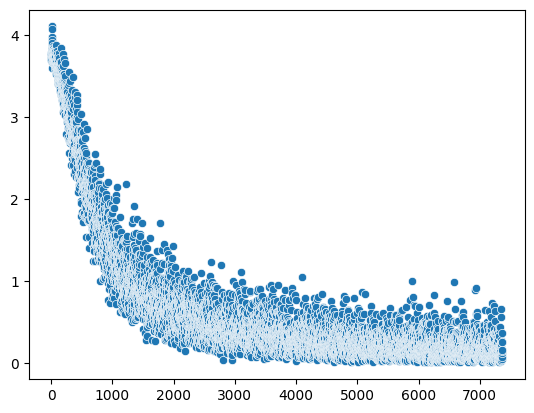

In [28]:
sns.scatterplot(loss_epoch)

In [29]:
predictions = trainer.predict(model, dataloaders=test_loader)

/Users/ruasvmv/common/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

/Users/ruasvmv/common/lib/python3.9/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [30]:
labels = []
for pred in predictions:
    labels += pred.detach().numpy().tolist()

In [31]:
idx_to_class = {v: k for k, v in train_dataset.dataset.class_to_idx.items()}

In [32]:
submit = pd.read_csv('~/Downloads/journey-springfield/sample_submission.csv')

In [33]:
names = []
for path, _ in test_dataset.samples:
    names.append(path.split('/')[-1])

In [34]:
submit['Expected'] = [idx_to_class[i] for i in labels]
submit['Id'] = names

In [35]:
submit.to_csv('sol_6.csv', index=False)

In [36]:
submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,maggie_simpson
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum
